In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets
import torchvision.models.vgg as vgg
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torchsummary import summary
import time
import glob
import importlib



import data
importlib.reload(data)
import loss_network
importlib.reload(loss_network)
import transformer_network
importlib.reload(transformer_network)

<module 'transformer_network' from '/Users/maheshjayasankar/Documents/Style-Transfer/transformer_network.py'>

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

USING_GPU = True
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    USING_GPU = False


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET_PATH = './data/train/'

train_ds = data.get_dataset(DATASET_PATH, IMAGE_SIZE)
train_dl = data.get_dataloader(train_ds, BATCH_SIZE)

In [4]:
loss_net = loss_network.LossNetwork()
loss_net.to('cpu')

summary(loss_net,(3,IMAGE_SIZE,IMAGE_SIZE), device='cpu')
loss_net.to(device)

/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

LossNetwork(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

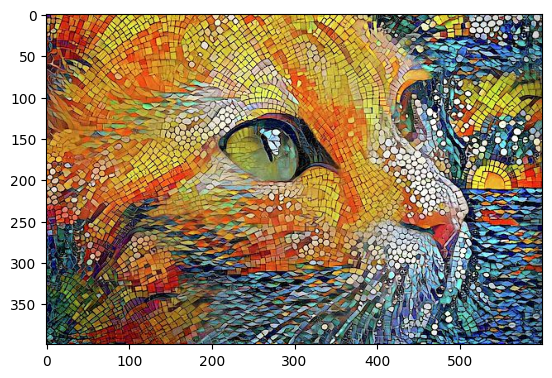

In [5]:
style_img = Image.open('./data/style_images/ginger_cat.jpg').convert('RGB')
plt.imshow(style_img)

In [6]:
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),#COCO Mean
                            #(0.229, 0.224, 0.225))] #COCO STD
    ])(style_img).unsqueeze(0)

    style_img_tensor = style_img_tensor.to(device)


In [7]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [8]:
with torch.no_grad():
    style_loss_features = loss_net(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [9]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [10]:
transformer = transformer_network.TransformerNet()
mse_loss = torch.nn.MSELoss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [11]:
torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    while True:
        for x, _ in train_dl:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = loss_net(y)
            features_xc = loss_net(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                transformer.train()
                
            if count >= steps:
                return

In [12]:

CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e5
REGULARIZATION = 1e-6
LOG_INTERVAL = 50

LR = 1e-3
optimizer = torch.optim.Adam(transformer.parameters(), LR)

In [13]:
len(train_dl)

29572

In [14]:
train(1000, 0)

/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: The operator 'aten::random_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return func(*args, **kwargs)
/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: MPS: randperm op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Distributions.mm:347.)
  return func(*args, **kwargs)
/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torch/nn/functional.py:3931: UserWarning: MPS: passing scale factor to upsample ops is support

Sun Apr  9 20:16:16 2023 [50/1000] content: 19.15  style: 36.27  reg: 0.09 total: 55.507851
Sun Apr  9 20:17:03 2023 [100/1000] content: 20.18  style: 10.06  reg: 0.08 total: 30.321844
Sun Apr  9 20:17:52 2023 [150/1000] content: 21.06  style: 7.45  reg: 0.09 total: 28.605324
Sun Apr  9 20:18:40 2023 [200/1000] content: 20.23  style: 5.99  reg: 0.10 total: 26.314438
Sun Apr  9 20:19:28 2023 [250/1000] content: 19.51  style: 4.66  reg: 0.10 total: 24.270041
Sun Apr  9 20:20:15 2023 [300/1000] content: 20.23  style: 4.72  reg: 0.10 total: 25.043365
Sun Apr  9 20:21:03 2023 [350/1000] content: 19.37  style: 3.77  reg: 0.11 total: 23.241730
Sun Apr  9 20:21:50 2023 [400/1000] content: 19.74  style: 3.36  reg: 0.11 total: 23.202238
Sun Apr  9 20:22:37 2023 [450/1000] content: 18.54  style: 3.69  reg: 0.11 total: 22.340284
Sun Apr  9 20:23:25 2023 [500/1000] content: 18.60  style: 3.81  reg: 0.11 total: 22.515860
Sun Apr  9 20:24:12 2023 [550/1000] content: 18.60  style: 3.36  reg: 0.11 tota

In [15]:
optimizer = torch.optim.Adam(transformer.parameters(), LR * 0.5)
train(3000, 1000)

Sun Apr  9 20:36:45 2023 [50/3000] content: 17.20  style: 3.65  reg: 0.10 total: 20.957104
Sun Apr  9 20:37:31 2023 [100/3000] content: 17.36  style: 3.06  reg: 0.10 total: 20.519629
Sun Apr  9 20:38:17 2023 [150/3000] content: 17.00  style: 3.01  reg: 0.11 total: 20.115540
Sun Apr  9 20:39:02 2023 [200/3000] content: 17.15  style: 3.28  reg: 0.10 total: 20.532309
Sun Apr  9 20:39:48 2023 [250/3000] content: 17.00  style: 3.15  reg: 0.10 total: 20.250444
Sun Apr  9 20:40:34 2023 [300/3000] content: 16.75  style: 3.12  reg: 0.10 total: 19.972143
Sun Apr  9 20:41:21 2023 [350/3000] content: 16.89  style: 3.17  reg: 0.10 total: 20.169868
Sun Apr  9 20:42:09 2023 [400/3000] content: 16.18  style: 3.13  reg: 0.10 total: 19.412901
Sun Apr  9 20:42:58 2023 [450/3000] content: 15.34  style: 2.96  reg: 0.10 total: 18.401112
Sun Apr  9 20:43:46 2023 [500/3000] content: 16.29  style: 3.19  reg: 0.10 total: 19.586065
Sun Apr  9 20:44:34 2023 [550/3000] content: 16.57  style: 3.02  reg: 0.10 total:

In [16]:
save_model_path = "models/picaso_4000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [83]:

#LOG_INTERVAL = 100
#optimizer = torch.optim.Adam(transformer.parameters(), LR * 0.1)
#train(6000, 4000)

In [84]:
#save_model_path = "models/picaso_10000_unstable_vgg19.pth"
#torch.save(transformer.state_dict(), save_model_path)

In [17]:
fnames = glob.glob(DATASET_PATH + r"/*/*")
len(fnames)

118287

In [18]:
transformer = transformer.eval()

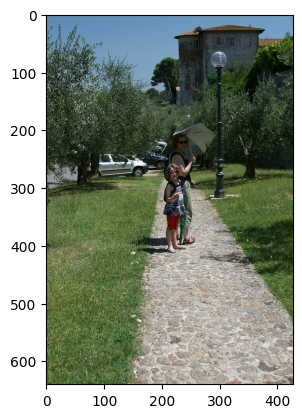

In [26]:
img = Image.open(fnames[70]).convert('RGB')
img_size = np.array(img).shape
plt.imshow(img)
img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),#COCO Mean
                            (0.229, 0.224, 0.225))] #COCO STD]
    )(img).unsqueeze(0)
img_tensor = img_tensor.to(device)


In [20]:
def recover_image(img):
    return (
        (
            img *
            np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
            np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [32]:

img_output = transformer(img_tensor)

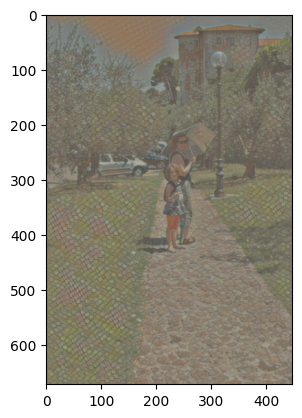

In [33]:
img_output = img_output.cpu()
img_output = img_output.detach().numpy()
#img_output = np.reshape(img_output, (3,448,448))
#img_output = img_output * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
#img_output = np.transpose(img_output, (1,2,0))
img_output = recover_image(img_output)
# img_output = np.reshape(img_output, img_size)
plt.imshow(np.squeeze(img_output))